<a href="https://colab.research.google.com/github/ziatdinovmax/Notebooks-for-papers/blob/master/rVAE_chemtransform_v2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring atomically resolved resolved data via variational autoencoder

Notebook by Maxim Ziatdinov (June 2020)

email: ziatdinovmax@gmail.com

In [1]:
#@title Download dataset
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From: https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
To: /content/3DStack13-1-dec.npy
157MB [00:02, 76.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
52.4MB [00:00, 167MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
2.45MB [00:00, 77.9MB/s]


Install AtomAI:

In [2]:
!pip install -q atomai==0.3.6

     |████████████████████████████████| 61kB 1.9MB/s 


Import needed modules:

In [3]:
from typing import Tuple, Type, Union, Dict

import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from atomai import atomstat, models

torch.manual_seed(0)
np.random.seed(0)

Load raw experimental data, neural network predictions and the extracted lattice coordiantes. The predictions were made using a neural network described in our earlier work in *Adv. Func. Mat. 29, 1904480 (2019)*.

In [4]:
STEM_real = np.load('3DStack13-1-exp.npy')
decoded_imgs = np.load('3DStack13-1-dec.npy')
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]

Visual inspection of the loaded data:

Text(0.5, 1.0, 'Atomic coordinates')

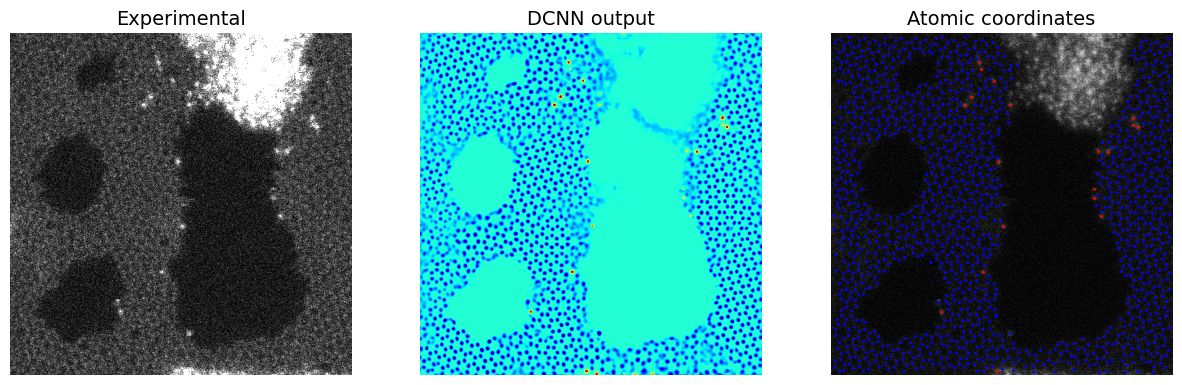

In [5]:
i = 49 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', Interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

Create a stack of sub-images centered on C (or Si) atoms:

In [8]:
window_size = 24
s = atomstat.imlocal(
    decoded_imgs[..., 0:1] + decoded_imgs[..., 1:2], # convert to a single channel (no background)
    lattice_coord, window_size, 0)

Run Gaussian mixture model on the stack:


GMM components


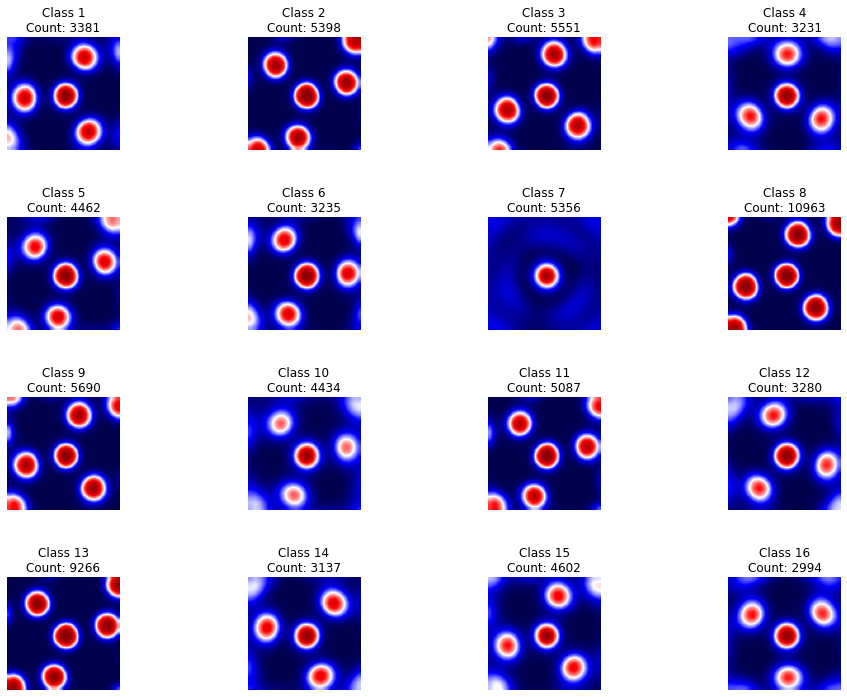

In [9]:
s.gmm(n_components=16, plot_results=True, random_state=42);

Prepare training data:

In [12]:
imstack = s.imgstack[..., 0] # will be used as training/test data
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

from sklearn.model_selection import train_test_split
imstack_train, imstack_test = train_test_split(
    imstack, test_size=0.15, shuffle=True, random_state=0)
print(imstack_train.shape, imstack_test.shape)

(68056, 24, 24) (12011, 24, 24)


Let's implement a rotationally-invariant VAE in Pytorch. Our implementation follows the recent [work](https://papers.nips.cc/paper/9677-explicitly-disentangling-image-content-from-translation-and-rotation-with-spatial-vae) of Bepler *et al.* who showed that by making a generative part of VAE explicitly dependent on the coordinates one can disentangle image content from rotations (and translations).

First we define our encoder and decoder neural networks:

In [13]:
class EncoderNet(nn.Module):
    """Encoder (inference) network"""
    def __init__(self,
                 dim: Tuple, 
                 latent_dim: int = 5,
                 num_layers: int = 2, 
                 hidden_dim: int = 32,
                 conv_encoder: bool = False) -> None:
        super(EncoderNet, self).__init__()
        n, m = dim
        self.conv_encoder = conv_encoder
        if self.conv_encoder:
            conv2dblock = models.conv2dblock
            self.econv = conv2dblock(num_layers, 1, hidden_dim, lrelu_a=0.1)
            self.reshape_ = hidden_dim * n * m   
        else:
            edense = []
            for i in range(num_layers):
                input_dim = n * m if i == 0 else hidden_dim
                edense.extend([nn.Linear(input_dim, hidden_dim), nn.Tanh()])
            self.edense = nn.Sequential(*edense)
            self.reshape_ = hidden_dim
        self.fc11 = nn.Linear(self.reshape_, latent_dim)
        self.fc12 = nn.Linear(self.reshape_, latent_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if not self.conv_encoder:
            x = x.reshape(-1, x.size(1) * x.size(2))
            x = self.edense(x)
        else:
            x = self.econv(x[:, None, ...])
            x = x.reshape(-1, self.reshape_)
        z_mu = self.fc11(x)
        z_logstd = self.fc12(x)
        return z_mu, z_logstd


class DecoderNet(nn.Module):
    """
    Spatial decoder network
    (based on https://arxiv.org/abs/1909.11663)
    """
    def __init__(self,
                 latent_dim: int, 
                 num_layers: int,
                 hidden_dim: int,
                 out_dim: Tuple) -> None:
        super(DecoderNet, self).__init__()
        self.reshape_ = out_dim
        self.fc_coord = nn.Linear(2, hidden_dim)
        self.fc_latent = nn.Linear(latent_dim, hidden_dim, bias=False)
        self.activation = nn.Tanh()
        fc_decoder = []
        for i in range(num_layers):
            fc_decoder.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        self.fc_decoder = nn.Sequential(*fc_decoder)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x_coord: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        batch_dim, n = x_coord.size()[:2]
        x_coord = x_coord.reshape(batch_dim * n, -1)
        h_x = self.fc_coord(x_coord)
        h_x = h_x.reshape(batch_dim, n, -1)
        h_z = self.fc_latent(z)
        h = h_x.add(h_z.unsqueeze(1))
        h = h.reshape(batch_dim * n, -1)
        h = self.activation(h)
        h = self.fc_decoder(h)
        h = self.out(h)
        out = h.reshape(batch_dim, *self.reshape_)
        return F.softplus(out)

We next define a single step for training/testing of rVAE:

In [14]:
def step(x_coord: torch.Tensor,
         x: torch.Tensor,
         decoder: Type[nn.Module],
         encoder: Type[nn.Module],
         coord_prior: float = 0.1,
         phi_prior: float = np.pi/3,
         mode: str = "train",
         use_gpu: bool = False) -> torch.Tensor:
    """
    Single training step
    """
    batch_dim = x.size(0)
    x_coord = x_coord.expand(batch_dim, *x_coord.size())
    if use_gpu:
        x = x.cuda()
    if mode=="eval":
        with torch.no_grad():
            z_mean, z_logsd = encoder(x)
    else:
        z_mean, z_logsd = encoder(x)
    z_sd = torch.exp(z_logsd)
    z_dim = z_mean.size(1)
    eps = x_coord.new(batch_dim, z_dim).normal_()
    z = z_mean + z_sd * eps
    phi = z[:, 0] # angle
    phi_sd, phi_logsd = z_sd[:, 0], z_logsd[:, 0]
    dx = z[:, 1:3] # translation
    dx = (dx * coord_prior).unsqueeze(1)
    z = z[:, 3:] # image content
    z_mean, z_sd, z_logsd = z_mean[:, 1:], z_sd[:, 1:], z_logsd[:, 1:]
    x_coord = transform_coord(x_coord, phi, dx, batch_dim)
    kl_rot = (-phi_logsd + np.log(phi_prior) + 
              phi_sd**2 / (2 * phi_prior**2) - 0.5) 
    if mode == "eval":
        with torch.no_grad():
            x_reconstr = decoder(x_coord, z)
    else:
        x_reconstr = decoder(x_coord, z)
    reconstr_error = -0.5 * torch.sum(
        (x_reconstr.view(batch_dim, -1) - x.view(batch_dim, -1))**2, 1).mean()
    kl_z = -z_logsd + 0.5 * z_sd**2 + 0.5 * z_mean**2 - 0.5
    kl_div = (kl_rot + torch.sum(kl_z, 1)).mean()

    return reconstr_error - kl_div


def transform_coord(coord: np.ndarray,
                    phi: float,
                    coord_dx: float,
                    batch_dim: int) -> torch.Tensor:
    """
    Rotation of coordinates by angle phi followed by translation
    """
    rotmat_r1 = torch.stack([torch.cos(phi), torch.sin(phi)], 1)
    rotmat_r2 = torch.stack([-torch.sin(phi), torch.cos(phi)], 1)
    rotmat = torch.stack([rotmat_r1, rotmat_r2], axis=1)
    coord = torch.bmm(coord, rotmat)

    return coord + coord_dx

Convert training and test data to torch format and transfer to GPU if available:

In [15]:
minibatch_size = 200
n = m = window_size # specify image lateral dims here
use_gpu = torch.cuda.is_available()

# Create a coordinate array
xx = torch.linspace(-1, 1, m)
yy = torch.linspace(1, -1, n)
x0, x1 = torch.meshgrid(xx, yy)
x_coord = torch.stack([x0.T.flatten(), x1.T.flatten()], axis=1)

# Training images
X_train = torch.from_numpy(imstack_train).float()
X_test = torch.from_numpy(imstack_test).float()

# Transfer training data to GPU if available
if use_gpu:
    X_train = X_train.cuda()
    X_test = X_test.cuda()
    x_coord = x_coord.cuda()

# Initialize dataloader
data_train = torch.utils.data.TensorDataset(X_train)
data_test = torch.utils.data.TensorDataset(X_test)
train_iterator = torch.utils.data.DataLoader(
    data_train, batch_size=minibatch_size, shuffle=True)
test_iterator = torch.utils.data.DataLoader(data_test, batch_size=minibatch_size)

Finally, train encoder and decoder jointly:

In [16]:
z_dim = 2 # number of latent dimensions
num_layers_e = 2 # number of layers in encoder
hidden_dim_e = 128 # number of hidden units / conv filters in each layer of encoder
num_layers_d = 2 # number of fully-connected layers in decoder
hidden_dim_d = 128 # number of neurons in each layer of decoder
dx_scale = 0.1 # standard deviation of translation latent variables
phi_prior = 0.1 # standard deviation on rotation prior
num_epochs = 250

if use_gpu:
    torch.cuda.empty_cache()

torch.manual_seed(0)
if use_gpu:
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Initialize encoder and decoder
decoder_net = DecoderNet(z_dim, num_layers_d, hidden_dim_d, (n, m))
encoder_net = EncoderNet((n, m), z_dim+3, num_layers_e, hidden_dim_e)

# Transfer models to GPU if available
if use_gpu:
    decoder_net.cuda()
    encoder_net.cuda()

# Select optimizer
params = list(decoder_net.parameters()) + list(encoder_net.parameters())
optim = torch.optim.Adam(params, lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    decoder_net.train()
    encoder_net.train()
    nb = 0
    elbo_epoch = 0
    for x, in train_iterator:
        b = x.size(0)
        elbo = step(
            x_coord, x, decoder_net, encoder_net, coord_prior=dx_scale,
            phi_prior=phi_prior, use_gpu=use_gpu)
        loss = -elbo
        loss.backward()
        optim.step()
        optim.zero_grad()
        elbo = elbo.item()
        nb += b
        delta = b * (elbo - elbo_epoch)
        elbo_epoch += delta/nb
    else:
        decoder_net.eval()
        encoder_net.eval()
        nb = 0
        elbo_epoch_test = 0
        for x, in test_iterator:
            b = x.size(0)
            elbo = step(
                x_coord, x, decoder_net, encoder_net, coord_prior=dx_scale,
                phi_prior=phi_prior, use_gpu=use_gpu, mode="eval")
            elbo = elbo.item()
            nb += b
            delta = b * (elbo - elbo_epoch_test)
            elbo_epoch_test += delta/nb
    template = 'Epoch: {}/{}, Training loss: {:.4f}, Test loss: {:.4f}'
    print(template.format(epoch+1, num_epochs, -elbo_epoch, -elbo_epoch_test))

Epoch: 1/250, Training loss: 31.2900, Test loss: 24.4283
Epoch: 2/250, Training loss: 24.3857, Test loss: 24.2709
Epoch: 3/250, Training loss: 24.2416, Test loss: 24.1359
Epoch: 4/250, Training loss: 24.0856, Test loss: 23.9517
Epoch: 5/250, Training loss: 23.9099, Test loss: 23.8098
Epoch: 6/250, Training loss: 23.7914, Test loss: 23.7112
Epoch: 7/250, Training loss: 23.6954, Test loss: 23.6219
Epoch: 8/250, Training loss: 23.6159, Test loss: 23.5484
Epoch: 9/250, Training loss: 23.5508, Test loss: 23.4931
Epoch: 10/250, Training loss: 23.3973, Test loss: 23.0560
Epoch: 11/250, Training loss: 22.2855, Test loss: 21.2478
Epoch: 12/250, Training loss: 19.9968, Test loss: 19.0356
Epoch: 13/250, Training loss: 18.4849, Test loss: 17.9432
Epoch: 14/250, Training loss: 17.4092, Test loss: 16.8288
Epoch: 15/250, Training loss: 16.2194, Test loss: 15.6542
Epoch: 16/250, Training loss: 15.1786, Test loss: 14.7758
Epoch: 17/250, Training loss: 14.2657, Test loss: 13.7649
Epoch: 18/250, Training

Save trained model and dowload it to a local machine:

In [17]:
torch.save({"encoder": encoder_net.state_dict(),
            "decoder": decoder_net.state_dict()},
            "/content/rVAE-GSi_24-2.tar")

from google.colab import files
files.download("/content/rVAE-GSi_24-2.tar")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Optionally we can load the already trained model from the disk:

In [18]:
load_saved_model = False

z_dim = 2 # number of latent dimensions
num_layers_e = 2 # number of layers in encoder
hidden_dim_e = 128 # number of hidden units in each layer of encoder
num_layers_d = 2 # number of fully-connected layers in decoder
hidden_dim_d = 128 # number of neurons in each layer of decoder


if load_saved_model:
    # Load weights from the disk
    weights_path = "/content/drive/My Drive/rVAE/rVAE-GSi_64-2.tar"
    model = torch.load(weights_path)
    encoder_net_weights = model["encoder"]
    decoder_net_weights = model["decoder"]
    # Initialize encoder and decoder
    encoder_net = EncoderNet((n, m), z_dim+3, num_layers_e, hidden_dim_e)
    decoder_net = DecoderNet(z_dim, num_layers_d, hidden_dim_d, (n, m))
    # Load weights into the models "skeletons"
    encoder_net.load_state_dict(encoder_net_weights)
    encoder_net.eval()
    decoder_net.load_state_dict(decoder_net_weights)
    decoder_net.eval();

Visualize the learned latent distribution in the image space:

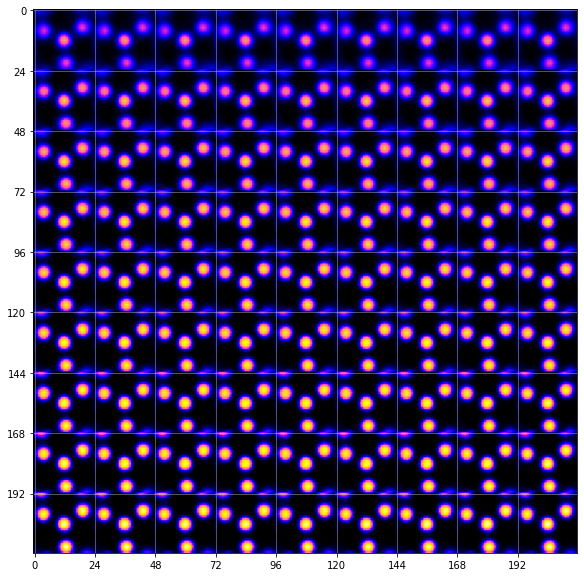

In [19]:
n = m = window_size
d = 9
batch_size = 1
figure = np.zeros((n * d, m * d))

# Get a stack of pixel coordinate (we'll need to pass them to decoder)
xx = torch.linspace(-1, 1, n)
yy = torch.linspace(1, -1, m)
x0, x1 = torch.meshgrid(xx, yy)
x_coord = torch.stack([x0.T.flatten(), x1.T.flatten()], axis=1)
x_coord = x_coord.expand(batch_size, x_coord.size(0), x_coord.size(1))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, d))
grid_y = norm.ppf(np.linspace(0.05, 0.95, d))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        z_sample = torch.from_numpy(z_sample).float()
        if torch.cuda.is_available():
            z_sample = z_sample.cuda()
            x_coord = x_coord.cuda()
            decoder_net.cuda()
        x_decoded = decoder_net(x_coord, z_sample)
        imloc = x_decoded.mean(axis=0).reshape(n, m)
        figure[i * n: (i + 1) * n, j * m: (j + 1) * m] = imloc.detach().cpu().numpy()

# Plot
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(figure, cmap='gnuplot2')
major_ticks = np.arange(0, d * window_size, window_size)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
ax.grid(which='major', alpha=0.6)
plt.show()  

Now let's see if/how we can interpret the "code" of our dataset. First define a class for encoding large volumes of data:

In [20]:
class encode_:
    """Encodes data by running inference network in a batch-by-batch fashion"""
    def __init__(self,
                 img: Union[torch.Tensor, np.ndarray],
                 encoder: Type[nn.Module], num_batches: int = 50,
                 latent_dim: int = 2) -> Tuple[np.ndarray]:
        
        self.num_batches, self.z_dim = num_batches, latent_dim
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).float()
        self.x = img.unsqueeze(0) if img.ndim == 2 else img
        self.encoder = encoder
        if torch.cuda.is_available():
            self.x = self.x.cuda()
            self.encoder.cuda()
        
    def inference(self, x_i: torch.Tensor) -> np.ndarray:
        with torch.no_grad():
            z_mean, _ = self.encoder(x_i)
        return z_mean.cpu().numpy()

    def batch_by_batch(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        batch_size = len(self.x) // self.num_batches
        z_mean_all = np.zeros((self.x.shape[0], self.z_dim+3))
        for i in range(self.num_batches):
            x_i = self.x[i*batch_size:(i+1)*batch_size]
            z_mean_all[i*batch_size:(i+1)*batch_size] = self.inference(x_i)
        x_i = self.x[(i+1)*batch_size:]
        if len(x_i) > 0:
            z_mean_all[(i+1)*batch_size:] = self.inference(x_i)
        return (z_mean_all[:,0], z_mean_all[:, 1:3], z_mean_all[:, 3:])

Encode the entire dataset:

In [21]:
z1, z2, z3 = encode_(imstack, encoder_net).batch_by_batch()

Plot results for the encoded angle and transaltion variables:

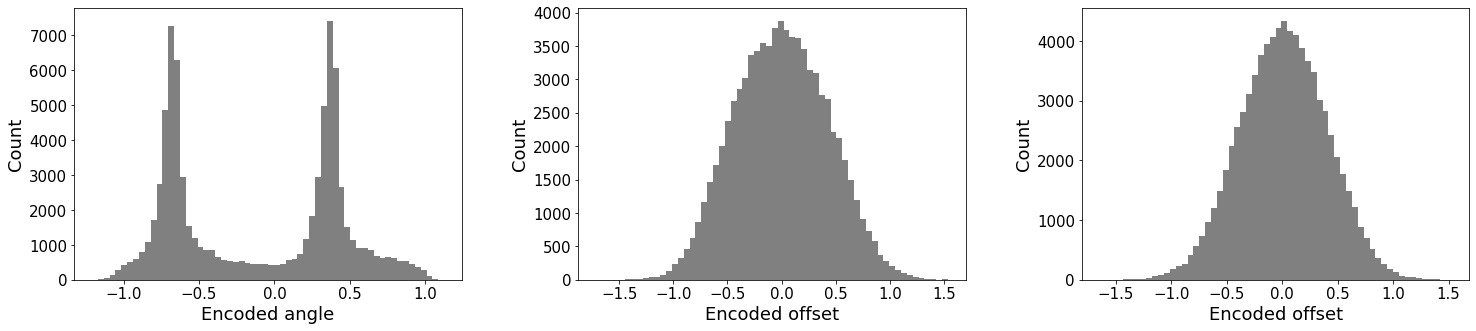

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='gray')
ax[1].hist(z2[:, 0], bins=60, color='gray')
ax[2].hist(z2[:, 1], bins=60, color='gray')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
ax[2].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

Next we weill plot evolution of our encoded variables (angle and image content) in time:

In [ ]:
import seaborn as sns

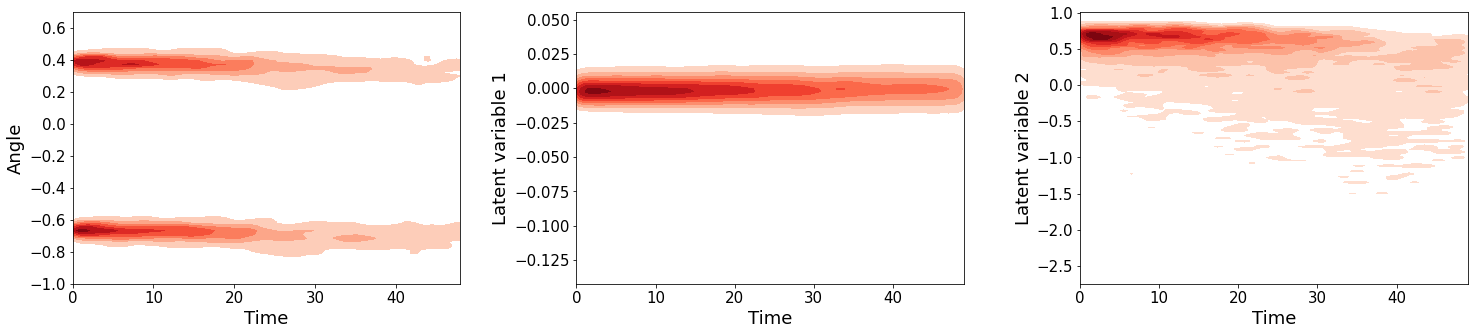

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].set_xlim(0, 48)
ax[0].set_ylim(-1., 0.7)
ax[0].set_ylabel("Angle", fontsize=18)
ax[1].set_ylabel("Latent variable 1", fontsize=18)
ax[2].set_ylabel("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.set_xlabel("Time", fontsize=18)
    _ax.tick_params(labelsize=15)
sns.kdeplot(frames_all, z1,
            cmap="Reds", shade=True, ax=ax[0],
            shade_lowest=False,  cut=0, bw=(1, 0.005))
sns.kdeplot(frames_all, z3[:, 0],
            cmap="Reds", shade=True, ax=ax[1],
            shade_lowest=False, cut=0, bw=(1, 0.005))
sns.kdeplot(frames_all, z3[:, 1],
            cmap="Reds", shade=True, ax=ax[2],
            shade_lowest=False, cut=0, bw=(1, 0.005))
plt.subplots_adjust(wspace=0.3)
plt.show()

Notice that the order of VAE's latent variables doesn't have any particular meaning (unlike, for example, in PCA). Hence in the figures in our paper we changed the order of the latent variables associated with image content.

Finally we map the encoded values associated with the subimages onto the original movie frames:

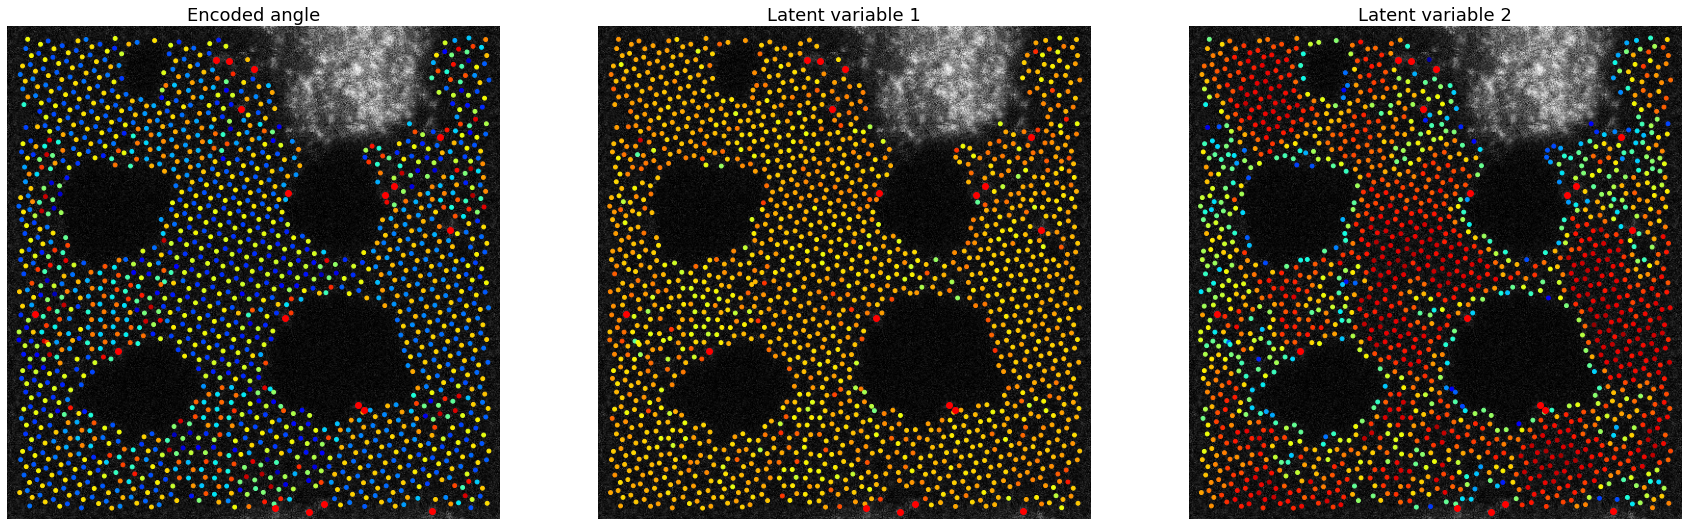

In [26]:
frame = 25 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting as well
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(STEM_real[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(STEM_real[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(STEM_real[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()